In [48]:
import collections
import glob
import json
import os

import numpy as np
import pandas as pd
from plotnine import *
import sklearn.metrics
import umap

from saged.utils import split_sample_names, create_dataset_stat_df, get_dataset_stats, parse_map_file

In [2]:
data_dir = '../../data'
metadata_path = os.path.join(data_dir, 'recount_metadata.tsv')
metadata_df = pd.read_csv(metadata_path, sep='\t')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (11,14,21,22,25,26,29,30,35,36,39,40,41,158,159,166,167,169,170) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
metadata_df

,rail_id,external_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,...,recount_seq_qc.%n,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line
1,1007887.0,SRR7252610,SRP149665,SRS3369783,SRX4157332,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.8,21.8,SRS3369783,NaN,NaN,rna-seq,rna-seq,NaN,NaN
2,1007903.0,SRR7252611,SRP149665,SRS3369784,SRX4157333,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.3,21,SRS3369784,NaN,NaN,rna-seq,rna-seq,NaN,NaN
3,1007918.0,SRR7252612,SRP149665,SRS3369785,SRX4157334,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.3,21.1,SRS3369785,NaN,NaN,rna-seq,rna-seq,NaN,NaN
4,2015537.0,SRR7252609,SRP149665,SRS3369782,SRX4157331,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.7,21.6,SRS3369782,NaN,NaN,rna-seq,rna-seq,NaN,NaN
5,1004924.0,SRR629557,SRP017465,SRS378921,SRX209056,SRA062599,Human Protein Atlas,Science for Life Lab,RNA sequencing results,RNA sequencing data for human cell lines.,...,0.0,32.8,15.4,SRS378921,NaN,NaN,rna-seq,rna-seq,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341146,NaN,NaN,SRP106855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341147,NaN,NaN,SRP103855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341148,NaN,NaN,SRP092128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341149,NaN,NaN,DRP003828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
sample_to_study = dict(zip(metadata_df['external_id'], metadata_df['study']))

In [5]:
assert sample_to_study['SRR629557'] == 'SRP017465'

In [6]:
in_files = glob.glob('../../results/sample-split.*.tsv')
print(in_files[:5])

['../../results/sample-split.deep_net_2.tsv', '../../results/sample-split.pytorch_lr_0.tsv', '../../results/sample-split.pytorch_lr_2.tsv', '../../results/sample-split.deep_net_1.tsv', '../../results/sample-split.pytorch_supervised_0.tsv']


In [7]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.837668,0.629207,"SRP026042,SRP019989,SRP035665,SRP010061,SRP045...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",476,0.1,pretrained,"0,0,0,0,9,5,0,6,11,14,12,0,16,14,9,0,0,0,10,4,...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,476
1,0.641779,0.298874,"SRP026042,SRP019989,SRP035665,SRP010061,SRP045...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",476,0.1,not_pretrained,"0,0,0,0,11,5,16,4,11,11,12,0,0,4,9,0,0,0,4,4,0...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,476
2,0.881711,0.667144,"SRP026042,SRP019989,SRP035665,SRP010061,SRP045...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",953,0.2,pretrained,"0,0,0,0,9,5,17,6,11,14,12,0,0,14,9,0,0,0,10,4,...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,953
3,0.735738,0.395284,"SRP026042,SRP019989,SRP035665,SRP010061,SRP045...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",953,0.2,not_pretrained,"0,0,0,0,9,5,17,9,17,5,12,0,0,4,9,0,0,0,4,4,0,1...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,953
4,0.879614,0.674390,"SRP042031,SRP020646,SRP034009,SRP023199,SRP010...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",1429,0.3,pretrained,"0,0,0,0,9,5,17,6,11,14,12,0,0,4,9,0,0,0,10,4,0...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,1429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.622744,0.230314,"SRP026052,SRP015138,SRP014542,SRP022166,SRP010...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",3813,0.8,not_pretrained,"0,12,0,11,17,0,4,0,4,4,3,0,12,4,4,0,3,4,4,0,12...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,3813
96,0.849350,0.548742,"SRP026052,SRP015138,SRP014542,SRP022166,SRP010...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4290,0.9,pretrained,"0,12,0,11,17,0,17,0,4,11,3,0,12,11,4,16,3,4,4,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4290
97,0.797734,0.444182,"SRP026052,SRP015138,SRP014542,SRP022166,SRP010...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4290,0.9,not_pretrained,"0,12,0,11,17,0,3,0,4,11,3,0,12,11,4,0,3,4,4,0,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4290
98,0.853966,0.560129,"SRP026052,SRP015138,SRP014542,SRP022166,SRP004...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4767,1.0,pretrained,"0,12,0,11,17,0,4,0,4,11,3,0,12,11,4,16,3,4,4,0...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4767


In [8]:
sample_model_predictions = {}
model_predictions = {}
# Process dataframe rows
for i, row in tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained'].iterrows():
    model = row['supervised']
    
    if model not in model_predictions:
        model_predictions[model] = {'predicted': [], 'true': []}
    
    encoder_string = row['val_encoders']
    encoder = json.loads(encoder_string)
    decoder = {number: label for label, number in encoder.items()}
    
    samples = row['val samples'].strip().split(',')
    
    predictions = row['val_predictions'].strip().split(',')
    truth = row['val_true_labels'].strip().split(',')
    pred_labels = []
    
    for prediction in predictions:
        if int(prediction) in decoder:
            pred_labels.append(decoder[int(prediction)])
        else:
            # https://github.com/greenelab/saged/issues/58
            pred_labels.append('invalid_index')
            
    predictions = pred_labels
    
    truth = [decoder[int(t)] for t in truth]
    
    assert len(truth) == len(predictions)
    
    model_predictions[model]['predicted'].extend(predictions)
    model_predictions[model]['true'].extend(truth)
    
    for sample, prediction, true_label in zip(samples, predictions, truth):
        if sample not in sample_model_predictions:
            sample_model_predictions[sample] = {}
        if model not in sample_model_predictions[sample]:
            sample_model_predictions[sample][model] = {'correct': 0, 'total': 0, 
                                                       'predictions': [], 'true_label': true_label}
        
        assert sample_model_predictions[sample][model]['true_label'] == true_label
        
        sample_model_predictions[sample][model]['predictions'].append(prediction)
        sample_model_predictions[sample][model]['total'] += 1
        
        correct = (prediction == true_label)
        if correct:
            sample_model_predictions[sample][model]['correct'] += 1

In [9]:
# Plot per-model confusion matrices
print(model_predictions.keys())
print(model_predictions['deep_net']['predicted'][:10])
print(model_predictions['deep_net']['true'][:10])

predicted = model_predictions['deep_net']['predicted']
true = model_predictions['deep_net']['true']

confusion_matrix = sklearn.metrics.confusion_matrix(true, predicted, labels=list(encoder.keys()))
confusion_matrix


confusion_df = pd.DataFrame(confusion_matrix, index = [l for l in encoder.keys()],
                            columns = [l for l in encoder.keys()])

dict_keys(['deep_net', 'pytorch_lr', 'three_layer_net', 'logistic_regression'])
['Blood', 'Blood', 'Blood', 'Blood', 'Lung', 'Cervix', 'Spinal Cord', 'Breast', 'Lung', 'Lung']
['Blood', 'Blood', 'Blood', 'Blood', 'Kidney', 'Colon', 'Stem Cell', 'Colon', 'Stem Cell', 'Prostate']


In [10]:
# Rows = True, columns = predicted
confusion_df['true_tissue'] = confusion_df.index
confusion_df

,Blood,Blood Vessel,Bone Marrow,Brain,Breast,Cervix,Colon,Epithelium,Heart,Kidney,...,Muscle,Placenta,Prostate,Skin,Spinal Cord,Stem Cell,Testis,Tonsil,Umbilical Cord,true_tissue
Blood,142527,41,109,286,214,670,3,13,6,276,...,7,8,241,31,322,628,14,298,235,Blood
Blood Vessel,267,109,2,11,77,79,1,13,1,39,...,0,1,20,2,38,218,0,4,111,Blood Vessel
Bone Marrow,3168,0,496,42,155,125,2,9,3,46,...,4,4,126,0,22,20,3,127,76,Bone Marrow
Brain,438,0,187,14340,537,152,1,22,3,138,...,8,7,181,40,105,608,0,14,74,Brain
Breast,181,0,22,662,22764,766,50,11,12,205,...,16,59,690,128,93,212,0,17,53,Breast
Cervix,97,7,61,299,579,15058,5,26,5,159,...,12,13,354,5,35,161,0,0,31,Cervix
Colon,38,0,8,180,552,534,1189,0,9,357,...,0,58,627,8,69,383,0,5,21,Colon
Epithelium,213,39,8,103,560,494,22,433,133,559,...,11,8,223,131,42,206,2,12,86,Epithelium
Heart,379,6,8,77,175,129,1,189,14824,10,...,99,11,326,41,25,178,0,11,60,Heart
Kidney,92,0,13,248,553,765,2,37,70,7414,...,36,13,244,11,111,549,0,12,26,Kidney


In [11]:
melted_df = confusion_df.melt(id_vars='true_tissue', var_name='pred_tissue')
melted_df['log_value'] = np.log(melted_df['value'])

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log


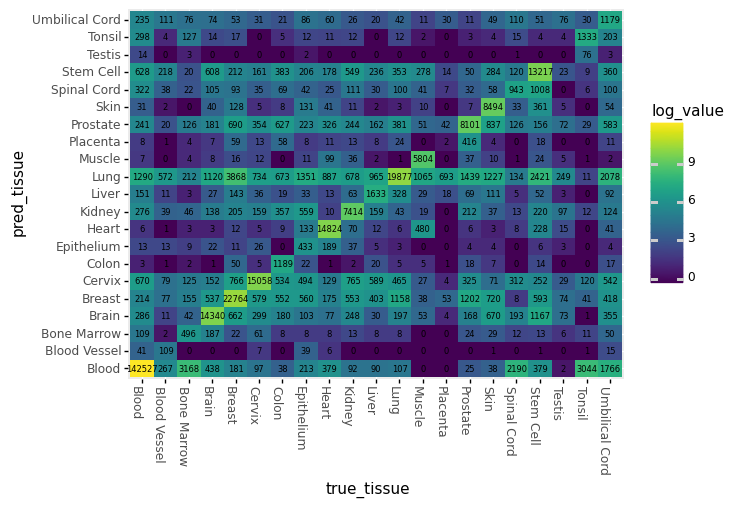

<ggplot: (8729576310881)>

In [12]:
plot = ggplot(melted_df, aes(x='true_tissue', y='pred_tissue', fill='log_value',)) 
plot += geom_tile() 
plot += geom_text(aes(label='value'), size=6)
plot += theme(axis_text_x=element_text(rotation=270, hjust=1))
plot

In [13]:
# TODO replace counts in melted_df with percent of that label?

In [14]:
# sample_model_predictions[sample][model]['total'] += 1
# sample_model_predictions[sample][model]['correct']

data_dict_list = []

for sample in sample_model_predictions:
    data_dict = {}
    data_dict['sample'] = sample
    for model in sample_model_predictions[sample]:
        total = sample_model_predictions[sample][model]['total']
        correct = sample_model_predictions[sample][model]['correct']
        acc = correct / total
        percent_wrong = 100 * (1 - acc)
        
        data_dict['{}_total'.format(model)] =  total 
        data_dict['{}_correct'.format(model)] = correct
        data_dict['{}_acc'.format(model)] = acc
        data_dict['{}_percent_wrong'.format(model)] = percent_wrong
    data_dict_list.append(data_dict)
        
acc_df = pd.DataFrame(data_dict_list)

In [15]:

acc_df

,sample,deep_net_total,deep_net_correct,deep_net_acc,deep_net_percent_wrong,pytorch_lr_total,pytorch_lr_correct,pytorch_lr_acc,pytorch_lr_percent_wrong,three_layer_net_total,three_layer_net_correct,three_layer_net_acc,three_layer_net_percent_wrong,logistic_regression_total,logistic_regression_correct,logistic_regression_acc,logistic_regression_percent_wrong
0,ERR356365,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.0,0.0
1,SRR031873,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.0,0.0
2,ERR789394,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.0,0.0
3,SRR1608655,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.000000,0.000000,30,30,1.0,0.0
4,SRR1038623,30,26,0.866667,13.333333,30,22,0.733333,26.666667,30,12,0.400000,60.000000,30,30,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11913,SRR1035698,30,27,0.900000,10.000000,30,29,0.966667,3.333333,30,26,0.866667,13.333333,30,30,1.0,0.0
11914,SRR857238,30,0,0.000000,100.000000,30,0,0.000000,100.000000,30,0,0.000000,100.000000,30,0,0.0,100.0
11915,SRR1054290,30,24,0.800000,20.000000,30,22,0.733333,26.666667,30,7,0.233333,76.666667,30,30,1.0,0.0
11916,SRR1027468,30,0,0.000000,100.000000,30,0,0.000000,100.000000,30,0,0.000000,100.000000,30,0,0.0,100.0


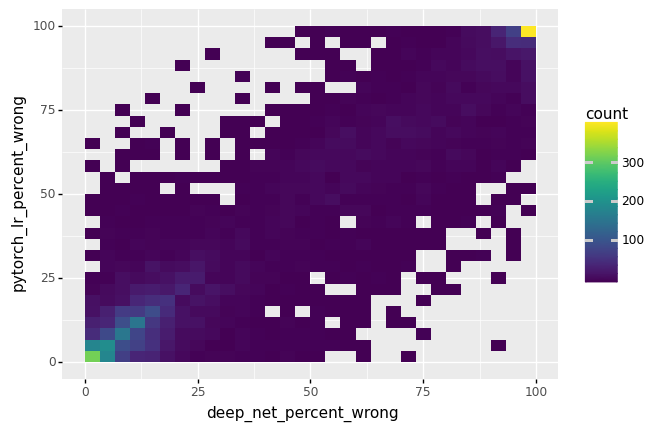

<ggplot: (8729575568997)>

In [16]:
plot = ggplot(acc_df, aes(x='deep_net_percent_wrong', y='pytorch_lr_percent_wrong'))
plot += geom_bin2d()
plot

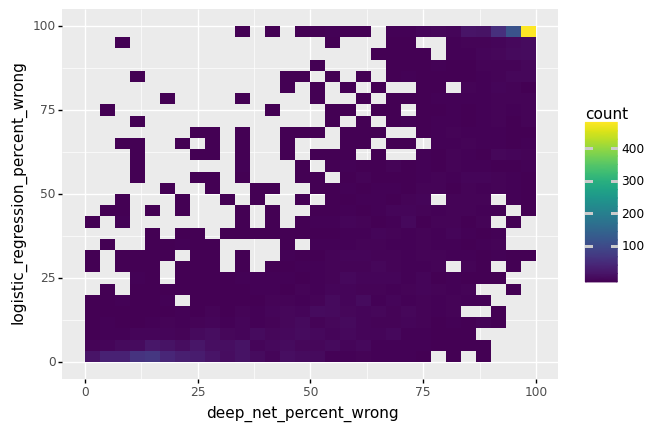

<ggplot: (8729575549085)>

In [17]:
plot = ggplot(acc_df, aes(x='deep_net_percent_wrong', y='logistic_regression_percent_wrong'))
plot += geom_bin2d()
plot

In [18]:
# Collect all samples misclassified by all models in every case
hard_samples = []
for sample in sample_model_predictions:
    good_prediction = False
    for model in sample_model_predictions[sample]:
        correct = sample_model_predictions[sample][model]['correct']
        if correct > 0:
            good_prediction = True
    
    if not good_prediction:
        hard_samples.append(sample)

In [19]:
print(len(hard_samples))

studies = set([sample_to_study[sample] for sample in hard_samples])
print(len(studies))

print(studies)

349
119
{'SRP014688', 'SRP017019', 'SRP006970', 'SRP005279', 'SRP015439', 'SRP016059', 'SRP028705', 'SRP018778', 'SRP045048', 'SRP041255', 'SRP011927', 'SRP040692', 'SRP028336', 'SRP018028', 'SRP029452', 'SRP019810', 'SRP022876', 'SRP036133', 'SRP012695', 'SRP023111', 'SRP014487', 'SRP012295', 'SRP033266', 'SRP028902', 'SRP038101', 'SRP007359', 'SRP009029', 'SRP007461', 'SRP002079', 'SRP015761', 'SRP033711', 'SRP017378', 'SRP028554', 'SRP014906', 'SRP035477', 'SRP010907', 'SRP026690', 'SRP007508', 'SRP012557', 'SRP020556', 'SRP011107', 'SRP000941', 'SRP001371', 'SRP028804', 'SRP019240', 'SRP028822', 'SRP022054', 'SRP041846', 'SRP043221', 'SRP032922', 'SRP019374', 'SRP031478', 'SRP041367', 'SRP039591', 'SRP018403', 'SRP018317', 'SRP017199', 'SRP038759', 'SRP013984', 'SRP015361', 'SRP019241', 'SRP023270', 'SRP019207', 'SRP012096', 'SRP011895', 'SRP021214', 'SRP019222', 'SRP003754', 'SRP008746', 'SRP033491', 'SRP012015', 'SRP007412', 'SRP009386', 'SRP040694', 'SRP019961', 'SRP044668', 'SR

In [62]:
print(hard_samples[:5])

['SRR901292', 'SRR1057941', 'SRR423929', 'SRR771240', 'SRR786804']


### Are all samples in a study with hard samples unclassifiable?

In [20]:
samples_in_bad_studies = 0
for sample, study in sample_to_study.items():
    if study in studies:
        samples_in_bad_studies += 1

print(len(hard_samples), samples_in_bad_studies, len(hard_samples) / samples_in_bad_studies)

349 2485 0.14044265593561367


For each sample that is universally incorrectly classified, there are six other in the same study that are fine

### Are there any hints in the metadata about why the samples are hard to classify?

In [25]:
metadata_df = metadata_df.set_index('external_id')

In [26]:
metadata_df = metadata_df[metadata_df.index.notnull()]
metadata_df

,rail_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,sra.study_description,...,recount_seq_qc.%n,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line
external_id,,,,,,,,,,,,,,,,,,,,,
SRR7252610,1007887.0,SRP149665,SRS3369783,SRX4157332,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,0.0,35.8,21.8,SRS3369783,NaN,NaN,rna-seq,rna-seq,NaN,NaN
SRR7252611,1007903.0,SRP149665,SRS3369784,SRX4157333,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,0.0,35.3,21,SRS3369784,NaN,NaN,rna-seq,rna-seq,NaN,NaN
SRR7252612,1007918.0,SRP149665,SRS3369785,SRX4157334,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,0.0,35.3,21.1,SRS3369785,NaN,NaN,rna-seq,rna-seq,NaN,NaN
SRR7252609,2015537.0,SRP149665,SRS3369782,SRX4157331,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,0.0,35.7,21.6,SRS3369782,NaN,NaN,rna-seq,rna-seq,NaN,NaN
SRR629557,1004924.0,SRP017465,SRS378921,SRX209056,SRA062599,Human Protein Atlas,Science for Life Lab,RNA sequencing results,RNA sequencing data for human cell lines.,NaN,...,0.0,32.8,15.4,SRS378921,NaN,NaN,rna-seq,rna-seq,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7516583,4808929.0,SRP153228,SRS3542937,SRX4386623,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,0.0,39.2,28.8,SRS3542937,NaN,NaN,rna-seq,scrna-seq,NaN,NaN
SRR7516584,4808992.0,SRP153228,SRS3542950,SRX4386624,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,0.0,38.6,27.6,SRS3542950,NaN,NaN,rna-seq,scrna-seq,NaN,NaN
SRR7516586,4809120.0,SRP153228,SRS3542952,SRX4386626,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,0.0,39,27.9,SRS3542952,NaN,NaN,rna-seq,scrna-seq,NaN,NaN


In [27]:
for col in metadata_df.columns:
    print(col)

rail_id
study
sra.sample_acc.x
sra.experiment_acc
sra.submission_acc
sra.submission_center
sra.submission_lab
sra.study_title
sra.study_abstract
sra.study_description
sra.experiment_title
sra.design_description
sra.sample_description
sra.library_name
sra.library_strategy
sra.library_source
sra.library_selection
sra.library_layout
sra.paired_nominal_length
sra.paired_nominal_stdev
sra.library_construction_protocol
sra.platform_model
sra.sample_attributes
sra.experiment_attributes
sra.spot_length
sra.sample_name
sra.sample_title
sra.sample_bases
sra.sample_spots
sra.run_published
sra.size
sra.run_total_bases
sra.run_total_spots
sra.num_reads
sra.num_spots
sra.read_info
sra.run_alias
sra.run_center_name
sra.run_broker_name
sra.run_center
recount_project.project
recount_project.organism
recount_project.file_source
recount_project.metadata_source
recount_project.date_processed
recount_qc.aligned_reads%.chrm
recount_qc.aligned_reads%.chrx
recount_qc.aligned_reads%.chry
recount_qc.bc_auc.all_

In [28]:
hard_sample_df = metadata_df.loc[hard_samples]
hard_sample_df

,rail_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,sra.study_description,...,recount_seq_qc.%n,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line
external_id,,,,,,,,,,,,,,,,,,,,,
SRR901292,1856092.0,SRP026044,SRS445234,SRX306189,SRA091125,GEO,NaN,Multiple roles for LEC in initiation and elong...,The small nuclear RNA (snRNA) genes have been ...,NaN,...,0.0,36.5,22.8,SRS445234,NaN,Colon,rna-seq,rna-seq,NaN,NaN
SRR1057941,1086490.0,SRP020556,SRS518954,SRX398502,SRA072653,GEO,NaN,Genome-wide probing of RNA structure reveals a...,We present an approach for globally monitoring...,NaN,...,0.0,36.9,21.2,SRS518954,NaN,Bone Marrow,rna-seq,rna-seq,NaN,NaN
SRR423929,510287.0,SRP011085,SRS295689,SRX124473,SRA050382,UMIGS,Genomics Resource Core,Characterization of transcriptome dynamics in ...,Candida albicans is the major invasive fungal ...,NaN,...,0.0,30.3,11.3,SRS295689,NaN,Heart,rna-seq,rna-seq,NaN,NaN
SRR771240,3182626.0,SRP019222,SRS400402,SRX248288,SRA068903,GEO,NaN,Epstein-Barr virus maintains lymphomas via its...,Epstein-Barr virus (EBV) has evolved exquisite...,NaN,...,0.2,38.1,22.5,SRS400402,NaN,Epithelium,rna-seq,scrna-seq,NaN,NaN
SRR786804,1507484.0,SRP001371,SRS373351,SRX252257,SRA010036,GEO,NaN,University of Washington Human Reference Epige...,Study of chromatin accessibility,"For data usage terms and conditions, please re...",...,0.0,37.5,18.2,SRS373351,rna-seq,Spinal Cord,rna-seq,rna-seq,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR857239,2115387.0,SRP022876,SRS424518,SRX282062,SRA079868,GEO,NaN,Differential gene expression by suppression of...,SOX2 is a transcription factor essential for p...,NaN,...,0.0,33.4,16,SRS424518,NaN,Stem Cell,rna-seq,scrna-seq,NaN,NaN
SRR650430,2393624.0,SRP018028,SRS386365,SRX218318,SRA065153,GEO,NaN,Differential gene expression and exon usage in...,"SF3B1, splicing factor 3b subunit 1 is a compo...",NaN,...,0.1,31.6,14.1,SRS386365,NaN,Bone Marrow,rna-seq,scrna-seq,NaN,NaN
SRR857238,2115353.0,SRP022876,SRS424517,SRX282061,SRA079868,GEO,NaN,Differential gene expression by suppression of...,SOX2 is a transcription factor essential for p...,NaN,...,0.0,33.5,15.9,SRS424517,NaN,Stem Cell,rna-seq,rna-seq,NaN,NaN


In [33]:
metadata_df['recount_seq_qc.avgq'] = pd.to_numeric(metadata_df['recount_seq_qc.avgq'], errors='coerce')
metadata_df = metadata_df[metadata_df['recount_seq_qc.avgq'].notnull()]
metadata_df

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,rail_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,sra.study_description,...,recount_seq_qc.%n,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line
external_id,,,,,,,,,,,,,,,,,,,,,
SRR7252610,1007887.0,SRP149665,SRS3369783,SRX4157332,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,0.0,35.8,21.8,SRS3369783,NaN,NaN,rna-seq,rna-seq,NaN,NaN
SRR7252611,1007903.0,SRP149665,SRS3369784,SRX4157333,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,0.0,35.3,21,SRS3369784,NaN,NaN,rna-seq,rna-seq,NaN,NaN
SRR7252612,1007918.0,SRP149665,SRS3369785,SRX4157334,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,0.0,35.3,21.1,SRS3369785,NaN,NaN,rna-seq,rna-seq,NaN,NaN
SRR7252609,2015537.0,SRP149665,SRS3369782,SRX4157331,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,0.0,35.7,21.6,SRS3369782,NaN,NaN,rna-seq,rna-seq,NaN,NaN
SRR629557,1004924.0,SRP017465,SRS378921,SRX209056,SRA062599,Human Protein Atlas,Science for Life Lab,RNA sequencing results,RNA sequencing data for human cell lines.,NaN,...,0.0,32.8,15.4,SRS378921,NaN,NaN,rna-seq,rna-seq,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7516583,4808929.0,SRP153228,SRS3542937,SRX4386623,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,0.0,39.2,28.8,SRS3542937,NaN,NaN,rna-seq,scrna-seq,NaN,NaN
SRR7516584,4808992.0,SRP153228,SRS3542950,SRX4386624,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,0.0,38.6,27.6,SRS3542950,NaN,NaN,rna-seq,scrna-seq,NaN,NaN
SRR7516586,4809120.0,SRP153228,SRS3542952,SRX4386626,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,0.0,39.0,27.9,SRS3542952,NaN,NaN,rna-seq,scrna-seq,NaN,NaN


<AxesSubplot:title={'center':'AvgQ Distributon'}, ylabel='Frequency'>

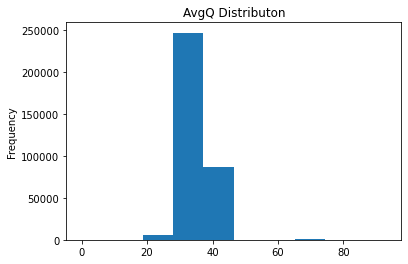

In [36]:
metadata_df['recount_seq_qc.avgq'] = metadata_df['recount_seq_qc.avgq'].astype(float)
metadata_df['recount_seq_qc.avgq'].plot.hist(title='AvgQ Distributon')

<AxesSubplot:title={'center':'AvgQ Distributon in Hard Samples'}, ylabel='Frequency'>

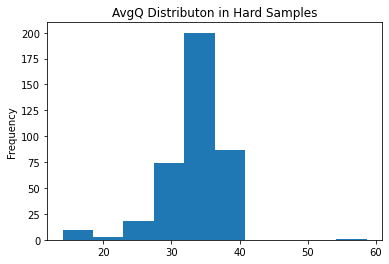

In [37]:
hard_sample_df['recount_seq_qc.avgq'] = hard_sample_df['recount_seq_qc.avgq'].astype(float)
hard_sample_df['recount_seq_qc.avgq'].plot.hist(title='AvgQ Distributon in Hard Samples')

<AxesSubplot:title={'center':'AvgQ Distributon'}, ylabel='Frequency'>

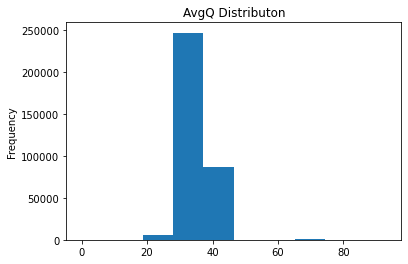

In [42]:
metadata_df['recount_seq_qc.errq'] = metadata_df['recount_seq_qc.avgq'].astype(float)
metadata_df['recount_seq_qc.errq'].plot.hist(title='AvgQ Distributon')

<AxesSubplot:title={'center':'AvgQ Distributon in Hard Samples'}, ylabel='Frequency'>

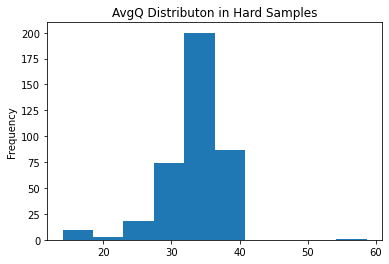

In [43]:
hard_sample_df['recount_seq_qc.errq'] = hard_sample_df['recount_seq_qc.avgq'].astype(float)
hard_sample_df['recount_seq_qc.errq'].plot.hist(title='AvgQ Distributon in Hard Samples')

In [ ]:
# TODO maybe run UMAP and see if the hard sample cluster together or something?
# TODO is it sparsity?
# TODO is there a relationship between bad samples and one of the classes?
# TODO basically, is there a predictable relationship between bad samples so that we can remove them or learn what causes them?

## Do the hard samples stand out in a UMAP embedding?

In [44]:
expression_df = pd.read_pickle("../../data/no_scrna_tpm.pkl")

In [92]:
# Running UMAP on 200k samples just makes a giant oval
is_hard = [sample in hard_samples for sample in expression_df.index]
expression_df['is_hard'] = is_hard

easy_df = expression_df[expression_df['is_hard'] == False]
easy_df = easy_df.sample(n=4000, random_state=42)
hard_df = expression_df[expression_df['is_hard']]
sampled_df = pd.concat([easy_df, hard_df])

# Remove column to extract expression for UMAP
is_hard = sampled_df['is_hard']
sampled_df = sampled_df.drop(['is_hard'], axis='columns')

sampled_df

,ENSG00000253132.1,ENSG00000172465.13,ENSG00000206013.2,ENSG00000214866.8,ENSG00000270390.1,ENSG00000235447.2,ENSG00000108602.17,ENSG00000279997.1,ENSG00000267112.1,ENSG00000234670.1,...,ENSG00000242960.1,ENSG00000274029.1,ENSG00000201945.1,ENSG00000121440.14,ENSG00000229616.2,ENSG00000088992.17,ENSG00000240964.3,ENSG00000111906.17,ENSG00000128596.16,ENSG00000255575.1
sample,,,,,,,,,,,,,,,,,,,,,
ERR2928074,0.0,0.0,0.086609,0.000000,0.001747,0.000000,0.000000,0.014992,0.024307,0.000322,...,0.000000,0.000000,0.139160,0.000000,2.760887e-04,0.070190,0.000000,0.000760,0.009590,0.000000
SRR5960243,0.0,0.0,0.006512,0.018265,0.005875,0.000000,0.000114,0.021912,0.011314,0.000137,...,0.002022,0.000014,0.056488,0.000000,9.757280e-05,0.043365,0.000000,0.002110,0.001748,0.000000
SRR6503121,0.0,0.0,0.002462,0.024689,0.000000,0.000185,0.000000,0.007607,0.000983,0.003275,...,0.004818,0.000000,0.008347,0.000055,1.527071e-04,0.032440,0.000000,0.000219,0.002331,0.000114
SRR6244049,0.0,0.0,0.003803,0.129517,0.000890,0.000000,0.000000,0.009872,0.000202,0.000427,...,0.102600,0.000000,0.017792,0.000354,2.980232e-07,0.063660,0.000043,0.007046,0.006474,0.000000
SRR7961364,0.0,0.0,0.017517,0.000000,0.000000,0.000000,0.000000,0.032837,0.000597,0.000703,...,0.000125,0.000000,0.122742,0.000296,3.474951e-05,0.019257,0.000000,0.000761,0.037354,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR952670,0.0,0.0,0.000379,0.006214,0.000000,0.000000,0.000000,0.006786,0.008171,0.001471,...,0.002861,0.000000,0.003365,0.000921,0.000000e+00,0.008865,0.000000,0.000097,0.000571,0.000000
SRR1248269,0.0,0.0,0.039215,0.011261,0.007679,0.000000,0.000000,0.025192,0.000638,0.001044,...,0.057739,0.000000,0.187744,0.000000,4.005432e-05,0.049438,0.000000,0.003405,0.034576,0.000000
SRR650429,0.0,0.0,0.007530,0.005150,0.002724,0.000011,0.000000,0.020569,0.000039,0.001187,...,0.080566,0.000000,0.023178,0.003080,7.808208e-06,0.373047,0.000000,0.001092,0.001447,0.000000


In [93]:
expression_matrix = sampled_df.to_numpy()
expression_matrix.shape

(4349, 5000)

In [94]:
reducer = umap.UMAP(transform_seed=42, random_state=42, n_components=2)

In [95]:
%%time
expression_umap = reducer.fit_transform(expression_matrix)

CPU times: user 12.5 s, sys: 251 ms, total: 12.8 s
Wall time: 7 s


In [96]:
umap_df = pd.DataFrame(expression_umap, index=sampled_df.index, columns=['UMAP1', 'UMAP2'])

In [97]:
umap_df

,UMAP1,UMAP2
sample,,
ERR2928074,-2.529983,4.744152
SRR5960243,-4.952123,3.587344
SRR6503121,-2.473183,-2.304391
SRR6244049,4.636759,-2.606193
SRR7961364,-0.551636,8.541205
...,...,...
SRR952670,-2.515734,-2.965608
SRR1248269,2.004352,0.804530
SRR650429,4.320385,-0.367934


In [98]:
umap_df['is_hard'] = is_hard

In [99]:
assert umap_df.loc['SRR1057941']['is_hard']

In [100]:
umap_df

,UMAP1,UMAP2,is_hard
sample,,,
ERR2928074,-2.529983,4.744152,False
SRR5960243,-4.952123,3.587344,False
SRR6503121,-2.473183,-2.304391,False
SRR6244049,4.636759,-2.606193,False
SRR7961364,-0.551636,8.541205,False
...,...,...,...
SRR952670,-2.515734,-2.965608,True
SRR1248269,2.004352,0.804530,True
SRR650429,4.320385,-0.367934,True


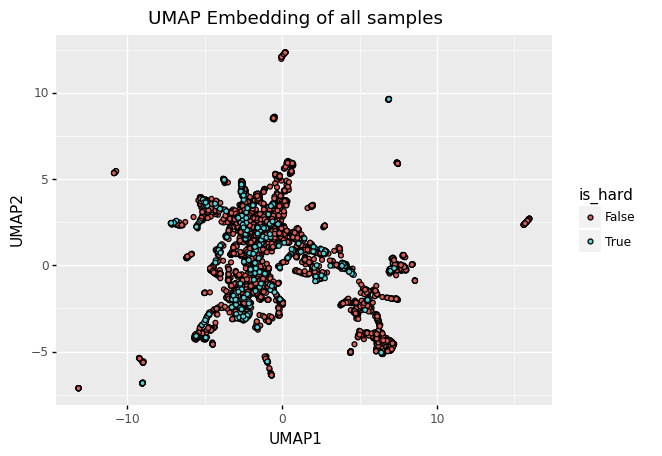

<ggplot: (8729348701009)>


In [102]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', fill='is_hard'))
plot += geom_point()
plot += ggtitle('UMAP Embedding of all samples')
print(plot)

In [ ]:
# What is the correlation in errors between different runs of the same model?

In [ ]:
# Are these correlations affected by the amount of data used?

In [ ]:
# What is the relationship between errors in different labels (confusion matrix)
# What do I need to plot this confusion matrix - True, pred, label names (can get via printing encoder as json)

In [ ]:
# To what extent are the relationships caused by label imbalance?

In [ ]:
# Does prediction diversity (e.g. guessing all labels instead of just most common) change as amount of data improves? Is this affected by model type?

In [ ]:
# Are all labels present in the train set? If not, how does this affect results